In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('Housing.csv')

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.head().T

,0,1,2,3,4
price,13300000,12250000,12250000,12215000,11410000
area,7420,8960,9960,7500,7420
bedrooms,4,4,3,4,4
bathrooms,2,4,2,2,1
stories,3,4,2,2,2
mainroad,yes,yes,yes,yes,yes
guestroom,no,no,no,no,yes
basement,no,no,yes,yes,yes
hotwaterheating,no,no,no,no,no
airconditioning,yes,yes,no,yes,yes


In [5]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [6]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [7]:
df.size

7085

In [8]:
for col in df.columns:
    print(df[col].nunique())

219
284
6
4
4
2
2
2
2
2
4
2
3


In [9]:
len(df)

545

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

y_train = df_train['price'].values
y_val   = df_val['price'].values
y_test  = df_test['price'].values

X_train_df = df_train.drop('price', axis=1)
X_val_df   = df_val.drop('price', axis=1)
X_test_df  = df_test.drop('price', axis=1)


In [12]:
numeric_cols = df.select_dtypes(include=['int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [14]:
from sklearn.feature_extraction import DictVectorizer

train_dict = X_train_df.to_dict(orient='records')
val_dict   = X_val_df.to_dict(orient='records')
test_dict  = X_test_df.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)
X_test  = dv.transform(test_dict)


In [16]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 4.1 MB/s eta 0:00:18
   - -------------------------------------- 1.8/72.0 MB 4.7 MB/s eta 0:00:15
   - -------------------------------------- 2.6/72.0 MB 4.5 MB/s eta 0:00:16
   - -------------------------------------- 3.4/72.0 MB 4.2 MB/s eta 0:00:17
   -- ------------------------------------- 4.2/72.0 MB 4.2 MB/s eta 0:00:16
   -- ------------------------------------- 5.0/72.0 MB 4.2 MB/s eta 0:00:16
   --- ------------------------------------ 5.8/72.0 MB 4.3 MB/s eta 0:00:16
   --- ------------------------------------ 6.3/72.0 MB 4.0 MB/s eta 0:00:17
   --- ------------------------------------ 6.3/72.0 MB 4.0 MB/s eta 0:00:17
   ---- ----------------------------------- 7.6/72.0 MB 3.7 MB/s eta 0:00:18
   ---- ----

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error


In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

In [20]:
from sklearn.metrics import mean_squared_error

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    results[name] = (rmse)

for name, (rmse) in results.items():
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.2f}")
    print()


--- Linear Regression ---
RMSE: 995785.34

--- Decision Tree ---
RMSE: 1648769.56

--- Random Forest ---
RMSE: 1054267.11

--- XGBoost ---
RMSE: 985845.63



In [21]:
max_depths = [3, 5, 7, 10]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 5]

In [23]:
results = []

for max_d in max_depths:
    for min_split in min_samples_splits:
        for min_leaf in min_samples_leafs:
            dt = DecisionTreeRegressor(
                max_depth=max_d,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
                random_state=42
            )
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_val)

            mse  = mean_squared_error(y_val, y_pred)
            rmse = np.sqrt(mse)
            
            results.append({
                'max_depth': max_d,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf,
                'RMSE': rmse,
                
            })

In [25]:
best_params = results_df.iloc[0]
dt_best = DecisionTreeRegressor(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
dt_best.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [26]:
feature_names = dv.get_feature_names_out()
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_best.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop 10 features by importance:")
print(feat_imp_df.head(10))


Top 10 features by importance:
                         feature  importance
2                           area    0.536887
5                      bathrooms    0.203801
9   furnishingstatus=unfurnished    0.065438
11                 guestroom=yes    0.053477
0             airconditioning=no    0.030112
1            airconditioning=yes    0.027756
17                   prefarea=no    0.026516
16                       parking    0.023178
3                    basement=no    0.016638
7     furnishingstatus=furnished    0.007534


In [37]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

num=[100, 150, 200]
max_depth_list=list(range(1,15,2))

results = []

# Nested loop for hyperparameter sweep
for n in num:
    for depth in max_depth_list:
        # Initialize model with current hyperparameters
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )

        # Fit model
        rf.fit(X_train, y_train)

        # Predict on validation set
        y_pred = rf.predict(X_val)

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        # Append results
        results.append([n, depth, rmse])

        print(f'n_estimators={n}, depth={depth}, RMSE={rmse:.3f}')

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'RMSE'])
df_results

n_estimators=100, depth=1, RMSE=1340921.432
n_estimators=100, depth=3, RMSE=1124728.282
n_estimators=100, depth=5, RMSE=1034444.896
n_estimators=100, depth=7, RMSE=1005032.697
n_estimators=100, depth=9, RMSE=1001154.243
n_estimators=100, depth=11, RMSE=998717.395
n_estimators=100, depth=13, RMSE=1000922.945
n_estimators=150, depth=1, RMSE=1340225.523
n_estimators=150, depth=3, RMSE=1127750.177
n_estimators=150, depth=5, RMSE=1039389.326
n_estimators=150, depth=7, RMSE=1013122.794
n_estimators=150, depth=9, RMSE=1005185.115
n_estimators=150, depth=11, RMSE=1005731.439
n_estimators=150, depth=13, RMSE=1006752.631
n_estimators=200, depth=1, RMSE=1338641.238
n_estimators=200, depth=3, RMSE=1127855.934
n_estimators=200, depth=5, RMSE=1037002.892
n_estimators=200, depth=7, RMSE=1010194.392
n_estimators=200, depth=9, RMSE=1004231.249
n_estimators=200, depth=11, RMSE=1003812.428
n_estimators=200, depth=13, RMSE=1004665.944


,n_estimators,max_depth,RMSE
0,100,1,1.340921e+06
1,100,3,1.124728e+06
2,100,5,1.034445e+06
3,100,7,1.005033e+06
4,100,9,1.001154e+06
5,100,11,9.987174e+05
6,100,13,1.000923e+06
7,150,1,1.340226e+06
8,150,3,1.127750e+06
9,150,5,1.039389e+06


In [53]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

num = [50, 100, 150, 200, 250, 300]
max_depth_list = list(range(3, 13))
learning = [0.05, 0.01, 0.5, 0.1, 1.0]

results = []

for n in num:
    for l in learning:
        for depth in max_depth_list:
            model = XGBRegressor(
                n_estimators=n,
                max_depth=depth,
                learning_rate=l,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="reg:squarederror",
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            results.append([n, depth, l, rmse])
            print(f"RMSE={rmse:.3f}, n_est={n}, max_dep={depth}, l_rate={l}")

df_results = pd.DataFrame(results, columns=["n_estimators", "max_depth", "learning_rate", "RMSE"])
best = df_results.loc[df_results['RMSE'].idxmin()]
print("\nBest combination:")
print(best)


RMSE=1029606.126, n_est=50, max_dep=3, l_rate=0.05
RMSE=991114.836, n_est=50, max_dep=4, l_rate=0.05
RMSE=965108.049, n_est=50, max_dep=5, l_rate=0.05
RMSE=978369.438, n_est=50, max_dep=6, l_rate=0.05
RMSE=985870.990, n_est=50, max_dep=7, l_rate=0.05
RMSE=1002109.212, n_est=50, max_dep=8, l_rate=0.05
RMSE=1002888.683, n_est=50, max_dep=9, l_rate=0.05
RMSE=1008949.589, n_est=50, max_dep=10, l_rate=0.05
RMSE=1011145.785, n_est=50, max_dep=11, l_rate=0.05
RMSE=1007915.143, n_est=50, max_dep=12, l_rate=0.05
RMSE=1405422.047, n_est=50, max_dep=3, l_rate=0.01
RMSE=1376020.742, n_est=50, max_dep=4, l_rate=0.01
RMSE=1362011.426, n_est=50, max_dep=5, l_rate=0.01
RMSE=1358474.897, n_est=50, max_dep=6, l_rate=0.01
RMSE=1360120.122, n_est=50, max_dep=7, l_rate=0.01
RMSE=1360501.493, n_est=50, max_dep=8, l_rate=0.01
RMSE=1360537.187, n_est=50, max_dep=9, l_rate=0.01
RMSE=1359894.795, n_est=50, max_dep=10, l_rate=0.01
RMSE=1360408.810, n_est=50, max_dep=11, l_rate=0.01
RMSE=1360589.979, n_est=50, ma

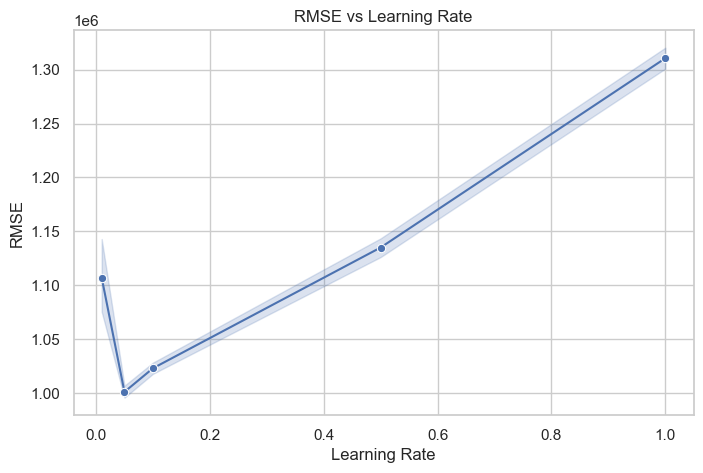

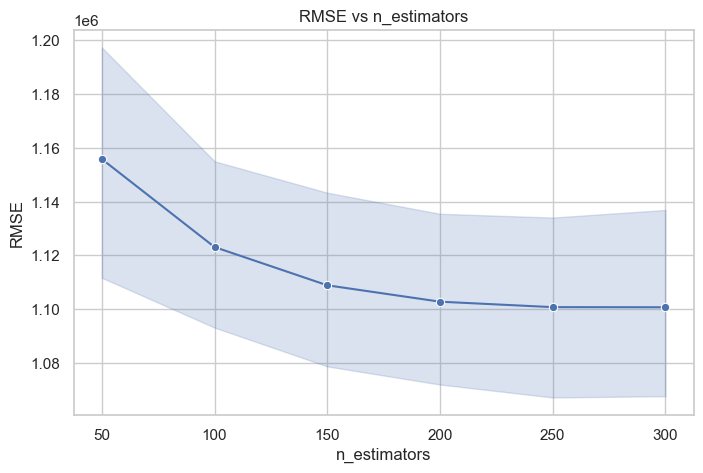

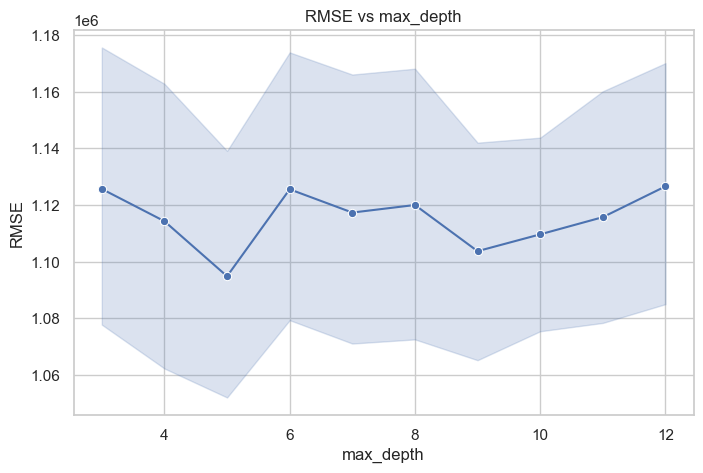

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Learning Rate vs RMSE
plt.figure(figsize=(8,5))
sns.lineplot(data=df_results, x="learning_rate", y="RMSE", marker="o")
plt.title("RMSE vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.show()

# n_estimators vs RMSE
plt.figure(figsize=(8,5))
sns.lineplot(data=df_results, x="n_estimators", y="RMSE", marker="o")
plt.title("RMSE vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.show()

# max_depth vs RMSE
plt.figure(figsize=(8,5))
sns.lineplot(data=df_results, x="max_depth", y="RMSE", marker="o")
plt.title("RMSE vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.show()


In [ ]:
import pickle

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open("lr_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)
